<a href="https://colab.research.google.com/github/bjatkin/Pepto-GAN/blob/master/Pepto_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports for everything here

In [0]:
import argparse
import os
import numpy as np
import math
from tqdm import tqdm

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Utility Functions

Genral functions that have broad use across differnt sections of the code base. Should be functions rather than classes.

In [0]:
def one_hot(peptide):
    encodings = []
    for aa in peptide:
      encoding = torch.zeros(len(gan_opt.amino_acids))
      index = gan_opt.amino_acids.index(aa)
      encoding[index] = 1.0
      encodings.append(encoding)
    return torch.stack(encodings)

def score_peptide(peptide):
  return tox_predictor(one_hot(peptide).unsqueeze(0).cuda()).item()

def decode_peptide(peptide):
  pep = ""
  for p in peptide:
    i = p.argmax()
    pep = pep + gan_opt.amino_acids[i]
  
  return pep

def decode_peptides(peptides):
  peps = []
  for peptide in peptides:
    peps.append(decode_peptide(peptide))
  
  return np.asarray(peps)

def save_model(model, file_name):
  torch.save(model.state_dict(), file_name)

def load_model(model, file_name):
  model.load_state_dict(torch.load(file_name))

# Network Opts

This section should contain global options that configure each network

In [0]:
# Toxic Classifier Options

class tox_opt():
  n_epochs=10
  batch_size=64
  lr=0.0005
  validate_every=500
  load_network = False
  load_model_file="tox_classifier.pt"
  save_model_file="tox_classifier.pt"


# GAN Options

class gan_opt():
  n_epochs=100
  batch_size=64
  lr=0.0002
  b1=0.5
  b2=0.999
  latent_dim=100
  peptide_length=7
  amino_acids="CDFGHILNRSVY"
  d_update_every=100
  load_discriminator=False
  load_disc_file="tox_discriminatro.pt"
  save_disc_file="tox_discriminator.pt"
  load_generator=False
  load_gen_file="tox_generator.pt"
  save_gen_file="tox_generator.pt"
  train_gan=True


# Toxic Peptide Classifier

the goal of this model is to predict the toxicity score of a peptide. This can then be used to access the success of the GAN

In [0]:
# -------------------------
# Toxic Peptide classifier
# -------------------------

class ToxicityPredictor(nn.Module):
  def __init__(self):
    super(ToxicityPredictor, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(int(len(gan_opt.amino_acids) * gan_opt.peptide_length), 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
    )

  def forward(self, pep):
    pep_flat = pep.view(pep.size(0), -1)
    tox = self.model(pep_flat)

    return tox

# Loss function
toxicity_loss = nn.L1Loss()

# Initialize Predictor
tox_predictor = ToxicityPredictor()

if cuda:
  tox_predictor.cuda()
  toxicity_loss.cuda()

# Optimizer
optimizer_tox = torch.optim.Adam(tox_predictor.parameters(), lr=tox_opt.lr)

In [0]:
# --------------------
# Peptides Dataloader
# --------------------
class ToxicPeptideDataset(Dataset):
  def __init__(self, file_name, labels_file_name="", train=True, soft=False):
    if soft:
      self.peptides = self.one_soft(np.load(file_name))
    else:
      self.peptides = self.one_hot(np.load(file_name))

    self.use_labels = False
    if labels_file_name != "":
      self.use_labels = True
      # These come in as strings and need to be floats
      self.labels = [float(l) for l in np.load(labels_file_name)]

      # Test train split
      split = len(self.labels) // 10
      if train:
        self.peptides = self.peptides[split:]
        self.labels = self.labels[split:]
      else:
        self.peptides = self.peptides[:split]
        self.labels = self.labels[:split]

  def one_hot(self, peptides):
    all_encodings = []
    for peptide in peptides:
      encodings = []
      for aa in peptide:
        encoding = torch.zeros(len(gan_opt.amino_acids))
        index = gan_opt.amino_acids.index(aa)
        encoding[index] = 1.0
        encodings.append(encoding)
      all_encodings.append(torch.stack(encodings))

    return all_encodings
  
  def one_soft(self, peptides, alpha=0.5):
    all_encodings = []
    for peptide in peptides:
      encodings = []
      for aa in peptide:
        cs = len(gan_opt.amino_acids)
        encoding = torch.ones(cs) * (alpha/(cs-1))
        index = gan_opt.amino_acids.index(aa)
        encoding[index] = 1 - alpha
        encodings.append(encoding)
      all_encodings.append(torch.stack(encodings))

    return all_encodings

    
  def __getitem__(self, index):
    if self.use_labels:
      return self.peptides[index], self.labels[index]
    return self.peptides[index]
    
  def __len__(self):
    return len(self.peptides)

tox_data_train = ToxicPeptideDataset("mostToxicNCSequences.npy", "mostToxicNCScores.npy", train=True)
tox_dataloader_train = torch.utils.data.DataLoader(tox_data_train, batch_size=tox_opt.batch_size, shuffle=True)

tox_data_test = ToxicPeptideDataset("mostToxicNCSequences.npy", "mostToxicNCScores.npy", train=False)
tox_dataloader_test = torch.utils.data.DataLoader(tox_data_test, batch_size=tox_opt.batch_size, shuffle=True)

In [0]:
def accuracy(y_hat, y_truth):
  diff = torch.abs(y_hat-y_truth)
  count = y_hat.size()[0]
  return (count - torch.sum(diff))/count

In [21]:
# ------------------------------
#  Toxicicty Predictor Training
# ------------------------------

losses = []
v_losses = []
acc = []
def tox_train():
  loop = tqdm(total=len(tox_dataloader_train) * tox_opt.n_epochs, position=0)
  for epoch in range(tox_opt.n_epochs):

      for i, (peps, toxs) in enumerate(tox_dataloader_train):
          peps = Variable(peps.type(Tensor))
          toxs = Variable(toxs.type(Tensor))
          optimizer_tox.zero_grad()

          y_hat = tox_predictor(peps)

          # loss = toxicity_loss(y_hat.squeeze(), toxs)
          # pdb.set_trace()
          loss = torch.sum(torch.abs(y_hat.squeeze()-toxs))
          loss.backward()
          losses.append(loss.item())
          optimizer_tox.step()
          last_acc = 0
          if i % tox_opt.validate_every:
            a = []
            for v_peps, v_toxs in tox_dataloader_test:
              v_peps = Variable(v_peps.type(Tensor))
              v_toxs = Variable(v_toxs.type(Tensor))
              v_y_hat = tox_predictor(v_peps)
              a.append(accuracy(v_y_hat.squeeze(), v_toxs).item())
            last_acc = np.mean(a)
            acc.append((len(losses), last_acc))

          loop.set_description("Epoch {}, Batch {}, Toxic_Loss {:.4f}, Accuracy {:.4f}".format(epoch, i, loss.item(), last_acc))
          loop.update()

# No need to retrain if we can just load the network from a file
if tox_opt.load_network:
  load_network(tox_predictor, tox_opt.load_model_file)
  quit()

tox_train()
save_model(tox_predictor, tox_opt.save_model_file)

# Plot accuracy and loss
plt.plot(losses, label='losses')
plt.title('Toxicicity Predictor Losses')
plt.legend()
plt.show()

a, b = zip(*acc)
plt.plot(a, b, label='accuracy')
plt.title('Tocicity Accuracy')
plt.legend()
plt.show()

Epoch 9, Batch 646, Toxic_Loss 2.4103, Accuracy 0.8782: 100%|█████████▉| 6469/6470 [07:24<00:00, 14.81it/s]

NameError: ignored

# Pepto GAN

this section contains the code to run a simple gan forward on the peptide dataset. Ultimately it should produce toxic peptides as its output

*be sure to re-run all the cells in this section each time the GAN is run otherwise the Generator and the Discriminator will not be re-initalized*

## Tweak #1

**Problem:**The generator network was really struggling to learn how to produce peptides. The probelm apeard to be that the discriminator was learning too quickly and turning the learning rate for the discriminator down enough to allow the generator to catch up was preventing the discriminator from learning useful information that would help imporve the generator. I hypothesize that the reason for this is that the one hot encodings we were using were too high contrast. Before the discriminator learning for valid peptide configurations or toxicities it instead looked only at contrast. It learned this so quickly that the generator could not adjust in time and was burried by the discriminator.

**Fix:**We fixed this by using label smoothing on our one hot peptide encoding.

**Result:**This resulted in a marked improvement of the GAN. the discriminator learning rate was increase by a factor of 5 (every 500 steps to every 100 steps). also the number of training epochs that the GAN was able to sustain jumped by an order of magnitued (10 epochs to 100 epocsh)

## Tweak #2
**Problem:**(See tweak #1)

**Fix:**Change the contrast on the latent z vector so it's very high to see if that promotes high contrast in the output.

**Result:**

In [0]:
# ---------------------------------------
# Define the Generator and Discriminator
# ---------------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(gan_opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(gan_opt.peptide_length * len(gan_opt.amino_acids))),
            nn.Tanh()
        )

    def forward(self, z):
        pep = self.model(z)
        pep = pep.view(pep.size()[0], gan_opt.peptide_length, len(gan_opt.amino_acids))
        pep = F.softmax(pep, dim=2)
        return pep


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(len(gan_opt.amino_acids) * gan_opt.peptide_length), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, pep):
        pep_flat = pep.view(pep.size(0), -1)
        validity = self.model(pep_flat)

        return validity

# Dataset
gan_data = ToxicPeptideDataset("mostToxicNCSequences.npy", soft=True)
gan_dataloader = torch.utils.data.DataLoader(gan_data, batch_size=gan_opt.batch_size, shuffle=True)

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=gan_opt.lr, betas=(gan_opt.b1, gan_opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=gan_opt.lr, betas=(gan_opt.b1, gan_opt.b2))

In [40]:
# --------------
#  GAN Training
# --------------

def gan_train():
  for epoch in range(gan_opt.n_epochs):

      for i, peps in enumerate(gan_dataloader):

          # Adversarial ground truths
          valid = Variable(Tensor(peps.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(peps.size(0), 1).fill_(0.0), requires_grad=False)

          # Configure input
          real_peps = Variable(peps.type(Tensor))

          # -----------------
          #  Train Generator
          # -----------------

          optimizer_G.zero_grad()

          # Sample noise as generator input
          z = Variable(Tensor(np.random.normal(0, 1, (peps.shape[0], gan_opt.latent_dim))))

          # Sample high constrast noise as generator input
          # z = Variable(Tensor(np.random.randint(2, (peps.shape[0], gan_opt.latent_dim))))

          # Generate a batch of images
          gen_peps = generator(z)

          # Loss measures generator's ability to fool the discriminator
          g_loss = adversarial_loss(discriminator(gen_peps), valid)

          g_loss.backward()
          optimizer_G.step()

          # ---------------------
          #  Train Discriminator - every d_update_every steps
          # ---------------------

          batches_done = epoch * len(gan_dataloader) + i
          if batches_done % gan_opt.d_update_every == 0:
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_peps), valid)
            fake_loss = adversarial_loss(discriminator(gen_peps.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

      print("epoch {}/{} d loss {:.4f}, g loss {:.4f}".format(epoch+1, gan_opt.n_epochs, d_loss.item(), g_loss.item()))
      for pep in gen_peps:
        name = decode_peptide(pep)
        score = score_peptide(name)
        if score < -0.4 and score > -1:
          print("{}: {:.6f}".format(name, score))
        if score <= -1:
          print("#--------------------#")
          print("# {}: {:.6f} #".format(name, score))
          print("#--------------------#")

if gan_opt.load_discriminator:
  load_model(discriminator, gan_opt.load_disc_file)

if gan_opt.load_generator:
  load_model(generator, gan_opt.load_gen_file)

if gan_opt.train_gan:
  gan_train()
  save_model(discriminator, gan_opt.save_disc_file)
  save_model(generator, gan_opt.save_gen_file)

epoch 1/100 d loss 0.6959, g loss 0.6901
IHVHIGI: -0.487520
YCFVVGC: -0.511137
epoch 2/100 d loss 0.6964, g loss 0.6891
LVGYFYG: -0.478704
LVGYFYG: -0.478704
CVIGCCS: -0.448950
CVIGCCS: -0.448950
epoch 3/100 d loss 0.6993, g loss 0.6761
YCSNYVY: -0.413975
RFHCHHL: -0.417949
RFHCHHL: -0.417949
RFHCHHL: -0.417949
epoch 4/100 d loss 0.6951, g loss 0.6873
CGGLIGF: -0.404582
#--------------------#
# VYFLICR: -1.005590 #
#--------------------#
VYFLIGR: -0.878897
CYLLCGR: -0.551251
epoch 5/100 d loss 0.6987, g loss 0.6720
epoch 6/100 d loss 0.6954, g loss 0.6885
FCCGYFS: -0.516822
ICYGYFS: -0.427909
ICYGYFS: -0.427909
FFYHYFS: -0.502018
CCYGFHI: -0.553137
epoch 7/100 d loss 0.6932, g loss 0.6895
VRFYFYN: -0.633927
VRFYFYN: -0.633927
VVFYFLN: -0.809342
YRFYFLN: -0.725282
VVFYFLN: -0.809342
epoch 8/100 d loss 0.6986, g loss 0.6728
NIDCHGY: -0.431471
epoch 9/100 d loss 0.6885, g loss 0.6986
YFCCGFC: -0.683560
CFCCGFC: -0.653205
CFDFGFC: -0.419078
FFCFGFC: -0.878596
epoch 10/100 d loss 0.6847, g 

Genrated Average: -0.430687, Dataset Average: -0.545215, Unique Peptides: 31/41362, Unique Percent 0.074948%


<BarContainer object of 30 artists>

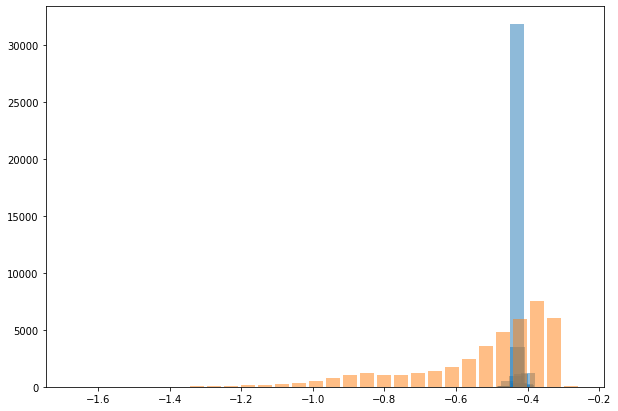

In [120]:
# ---------------
# GAN evaluation
# ---------------

# TODO: turn this into a general function and move it to its own section
# generate 50,000 peptides
z = Variable(Tensor(np.random.normal(0, 1, (len(tox_data_train), gan_opt.latent_dim))))

peptides = generator(z)

scores = tox_predictor(peptides)
hist, bin_edges = np.histogram(scores.detach().cpu(), bins=30)

data = torch.stack(tox_data_train[:len(tox_data_train)][0])
normal_scores = tox_predictor(data.cuda())
hist2, bin_edges_2 = np.histogram(normal_scores.detach().cpu(), bins=30)

generated_count = len(peptides)
unique_count = len(np.unique(decode_peptides(peptides)))
print("Genrated Average: {:.6f}, Dataset Average: {:.6f}, Unique Peptides: {}/{}, Unique Percent {:.6f}%".format(
      scores.mean(), normal_scores.mean(), unique_count, generated_count, (unique_count/generated_count)*100))
plt.figure(figsize=(10, 7))
plt.bar(bin_edges[1:], hist, align='center', alpha=0.5, width=0.04)
plt.bar(bin_edges_2[1:], hist2, align='center', alpha=0.5, width=0.04)

# Data Genreation

code that takes the original dataset and modifies it to be better/ more usable.

# Toxic Peptide Hall Of Fame

All the best most toxic peptides that get generated should get stuck here along with their score so we don't loose track of them





# Tests

Please ignore everything bellow this line. This is garbage code just used for testing random things.


In [5]:
sequences = np.load("mostToxicNCSequences.npy")
scores = np.load("mostToxicNCScores.npy")
print(len(sequences))
print(sequences[:5]) #Why are these peptides 7 aa's long? That seems wrong?


import csv

# Repair old data
new_sequences = []
with open('all_data_filtered.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  pbar = tqdm(total=45957)
  for row in csv_reader:
    line_count += 1
    for i, sequence in enumerate(sequences):
      if sequence in row[0] and scores[i] == row[1]:
        pbar.update()
        new_sequences.append(row[0])

  print(f'Processed {line_count} lines.')

print(len(new_sequences))
print(new_sequences[:5])

np.save("newMostToxicNCSequences", new_sequences)

  0%|          | 4/45957 [00:00<21:02, 36.38it/s]

45957
['DCHRGFV' 'YRCCIIV' 'VCVHFLC' 'CCDIYVC' 'HCFCFDI']


100%|█████████▉| 45954/45957 [25:52<00:00, 28.47it/s]

Processed 105416 lines.
45957
['CDCHRGFV', 'IYRCCIIV', 'HVCVHFLC', 'DCCDIYVC', 'FHCFCFDI']
